In [1]:
# get raspPy
from rasppy.misc import *

# set up matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# change the default plot size:
mpl.rcParams['figure.figsize'] = (20.0, 7)

# # because Lidar variable names are weird (not needed for python 3):
# import sys
# reload(sys)
# sys.setdefaultencoding('utf8')

## Table of Contents:
- [Introduction](#intro)
- [xarray basics](#xarray)
- [Lidar](#lidar)
- [Microwave Radiometer](#radiometer)
- [Lidar + Microwave Radiometer](#combo)

<a id="intro"></a>
## Introduction

raspPy is based on `xarray`, a Python package that works with data in a NetCDF-like format. `xarray` was created with weather scientists in mind and contains many useful functions for plotting and reorganizing data. To fully take advantage of `xarray`'s capabilities we recommend raspPy users familiarize themselves with the [`xarray` documentation](http://xarray.pydata.org/en/stable/).

raspPy includes two sets of code:
1. Helper functions to convert raw data into `xarray` objects, and
2. An `xarray` module with functions that simplify common tasks

The raspPy `xarray` module can be accessed with `xarray_object.rasp.function()`, as will be demonstrated in the examples below.

<a id="xarray"></a>
## `xarray` basics

In [2]:
# load Lidar data and print the xarray dataset
lidar = lidar_from_csv('data/lidar/cestm_66/20170225_whole_radial_wind_data.csv',
                       scans='data/lidar/cestm_66/20170225_scan.xml',
                       wind='data/lidar/cestm_66/20170225_reconstruction_wind_data.csv',
                       attrs={'lidar': 'CESTM_roof-66'})
# ^ The radial wind csv and scan file are required. Everything else is optional.
lidar

<xarray.Dataset>
Dimensions:           (Component: 3, Range: 117, Timestamp: 20907)
Coordinates:
  * Component         (Component) object 'x' 'y' 'z'
  * Range             (Range) float64 100.0 125.0 150.0 175.0 200.0 225.0 ...
  * Timestamp         (Timestamp) datetime64[ns] 2017-02-25T00:00:01.746431 ...
    Elevation         (Timestamp) float64 90.0 75.0 75.0 75.0 75.0 90.0 75.0 ...
    LOS               (Timestamp) int64 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 ...
    Azimuth           (Timestamp) float64 0.002106 0.001022 90.0 -180.0 ...
    Configuration ID  (Timestamp) int64 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...
Data variables:
    Error             (Timestamp, Range) float64 6.077 6.124 5.968 4.667 ...
    CNR               (Timestamp, Range) float64 -22.58 -22.28 -21.7 -21.41 ...
    Confidence        (Timestamp, Range) float64 100.0 100.0 100.0 100.0 ...
    Status            (Timestamp, Range) bool True True True True True True ...
    DRWS              (Timestamp, Range) floa

In the output above...
<dl>
<dt>Dimensions:</dt><dd>These are the basic coordinates that describe how the data is arranged in the computer.</dd>

<dt>Coordinates:</dt><dd>Coordinates typically describe the data in some way, for example by providing the location or time.</dd>

<dt>Data variables:</dt><dd>This is the data itself, the actual measurements taken by the instrument.</dd>

<dt>Attributes:</dt><dd>Attributes are arbitrary .... In this case the attributes came from the scan.xml file and describe the Lidar 
scanning mode.</dd>
</dl>

In [3]:
# get a subset of the data
lidar['CNR'].sel(Timestamp=slice('2017-02-25 12:00:00', '2017-02-25 12:30:00'), Range=slice(0, 1500))

<xarray.DataArray 'CNR' (Timestamp: 442, Range: 57)>
array([[-19.1134, -18.9707, -18.1277, ..., -21.8238, -22.4128, -22.9329],
       [-19.298 , -18.572 , -18.0652, ..., -21.8009, -22.2938, -23.4487],
       [-19.4312, -18.7719, -18.2974, ..., -23.2435, -23.6848, -24.1342],
       ..., 
       [-19.6665, -19.1499, -18.275 , ..., -21.5303, -22.0932, -22.9055],
       [-19.369 , -19.1175, -18.4094, ..., -21.3796, -22.1655, -22.4323],
       [-19.3014, -19.1057, -18.4213, ..., -21.9954, -22.2353, -23.2332]])
Coordinates:
  * Range             (Range) float64 100.0 125.0 150.0 175.0 200.0 225.0 ...
  * Timestamp         (Timestamp) datetime64[ns] 2017-02-25T12:00:03.729952 ...
    Azimuth           (Timestamp) float64 -90.0 0.001904 90.0 -180.0 -90.0 ...
    Elevation         (Timestamp) float64 75.0 75.0 75.0 75.0 75.0 90.0 75.0 ...
    LOS ID            (Timestamp) int64 3 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 ...
    Configuration ID  (Timestamp) int64 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ..

In [4]:
# get only the data where Status==1 (if Status==0 the value is replaced with nan)
lidar['CNR'].where(lidar['Status'])

<xarray.DataArray (Timestamp: 20907, Range: 117)>
array([[-22.5783, -22.2769, -21.7033, ...,      nan,      nan,      nan],
       [-22.9691, -22.3027, -21.8591, ...,      nan,      nan,      nan],
       [-22.3606, -22.1107, -21.7985, ...,      nan,      nan,      nan],
       ..., 
       [-19.1215, -19.8284, -19.3865, ...,      nan,      nan,      nan],
       [-18.6262, -18.8535, -18.8675, ...,      nan,      nan,      nan],
       [-18.2066, -18.5479, -18.1549, ...,      nan,      nan,      nan]])
Coordinates:
  * Range             (Range) float64 100.0 125.0 150.0 175.0 200.0 225.0 ...
  * Timestamp         (Timestamp) datetime64[ns] 2017-02-25T00:00:01.746431 ...
    Azimuth           (Timestamp) float64 0.002106 0.001022 90.0 -180.0 ...
    Elevation         (Timestamp) float64 90.0 75.0 75.0 75.0 75.0 90.0 75.0 ...
    LOS ID            (Timestamp) int64 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 ...
    Configuration ID  (Timestamp) int64 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...
Attr

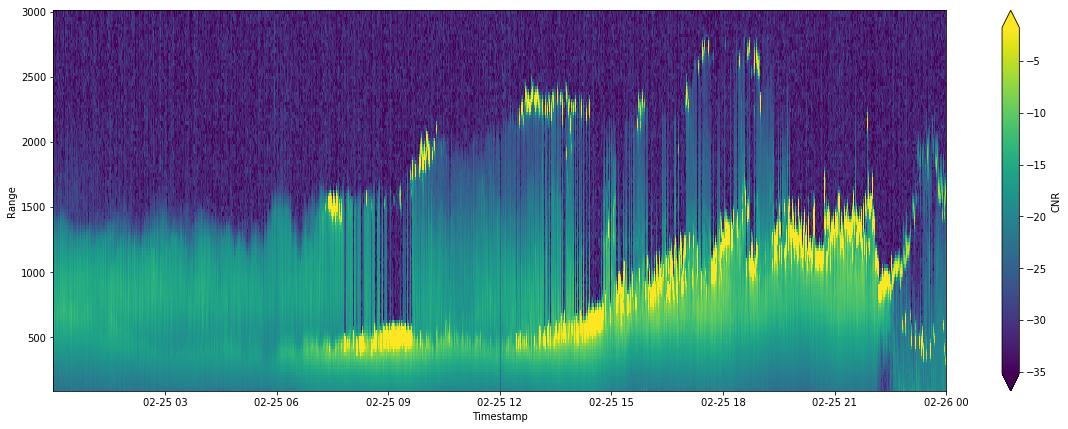

In [5]:
# plot CNR data
lidar['CNR'].plot(x='Timestamp', y='Range', robust=True, center=False)
# The 'robust' option attempts to ignore outliers when creating the color scale.

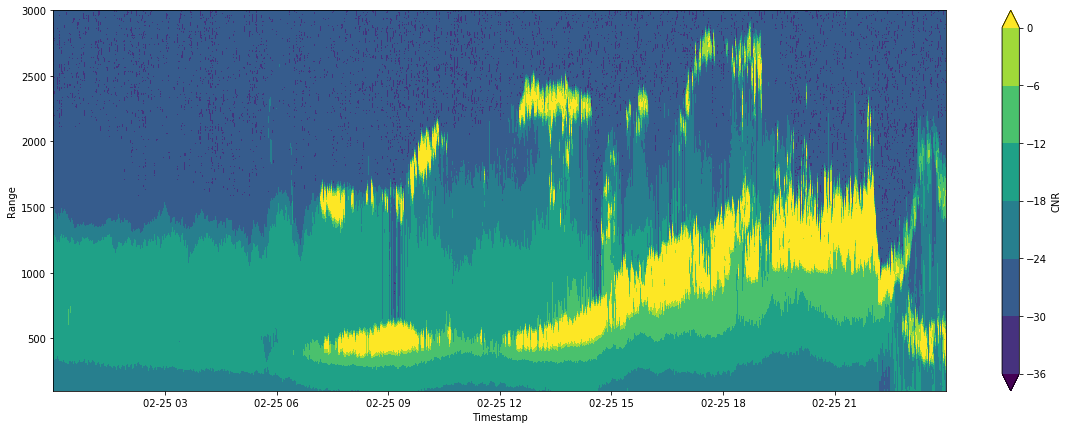

In [6]:
# filled contour plot
lidar['CNR'].plot.contourf(x='Timestamp', y='Range', robust=True, center=False)

In [7]:
# get 5-minute averages of the data
lidar['CNR'].resample('5T', 'Timestamp')

<xarray.DataArray 'CNR' (Timestamp: 288, Range: 117)>
array([[-22.388445, -22.103277, -21.791153, ..., -31.592959, -31.8454  ,
        -32.085381],
       [-22.794027, -22.486536, -22.133415, ..., -31.421459, -31.774447,
        -31.992527],
       [-22.294337, -21.961229, -21.608297, ..., -32.035788, -32.077544,
        -32.153401],
       ..., 
       [-19.927012, -20.114461, -20.190797, ..., -31.995332, -31.826394,
        -32.211533],
       [-19.322986, -19.482633, -19.482615, ..., -31.829693, -31.794933,
        -31.736727],
       [-18.726542, -18.919128, -19.069331, ..., -31.948671, -32.185829,
        -32.038504]])
Coordinates:
  * Range      (Range) float64 100.0 125.0 150.0 175.0 200.0 225.0 250.0 ...
  * Timestamp  (Timestamp) datetime64[ns] 2017-02-25 2017-02-25T00:05:00 ...

<a id="lidar"></a>
## Lidar

In [8]:
# Use Leosphere's algorithm to estimate wind speeds.
# These numbers should be identical* to the reconstruction wind data.
lidar.rasp.estimate_wind()

# *Identical to within .0002 m/s.
# The first 4 profiles in the data will also be missing wind estimates because the algorithm requires
# prior data to make the estimates.

<xarray.DataArray (Timestamp: 20907, Component: 3, Range: 117)>
array([[[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       ..., 
       [[  9.961023,  11.780381, ...,        nan,        nan],
        [ -5.594544,  -4.275514, ...,        nan,        nan],
        [ -2.734061,  -2.560878, ...,        nan,        nan]],

       [[  9.961023,  11.780381, ...,        nan,        nan],
        [ -5.391873,  -2.956467, ...,        nan,        nan],
        [ -2.755476,  -2.700252, ...,        nan,        nan]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2017-02-25T00:00:01.746431 ...
  * Component  (Component) object 'x' 'y' 'z'
  * Range      (Range) floa

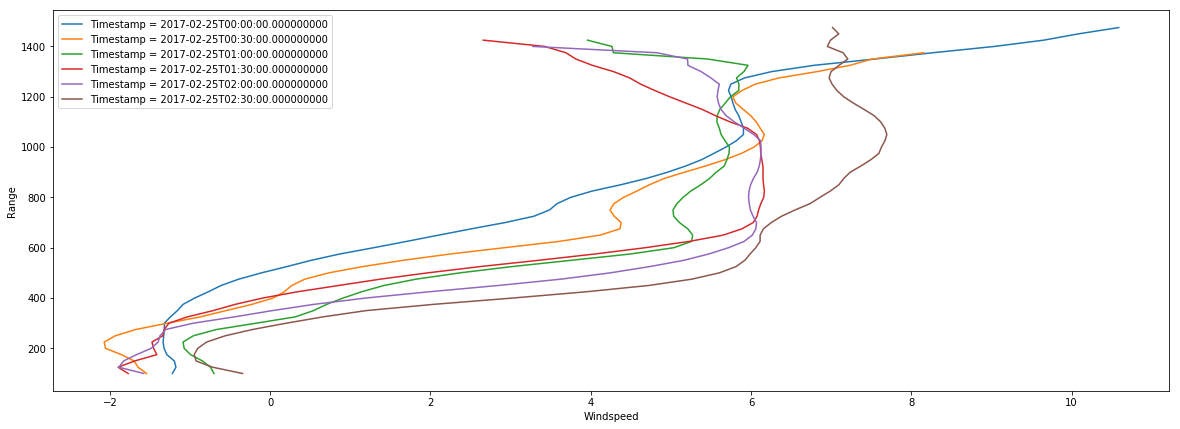

In [11]:
# vertical profile by timestamp
lidar['Windspeed'].sel(Component='x').resample('30T', 'Timestamp').isel(Timestamp=slice(0,6)).rasp.plot_profile(y='Range')

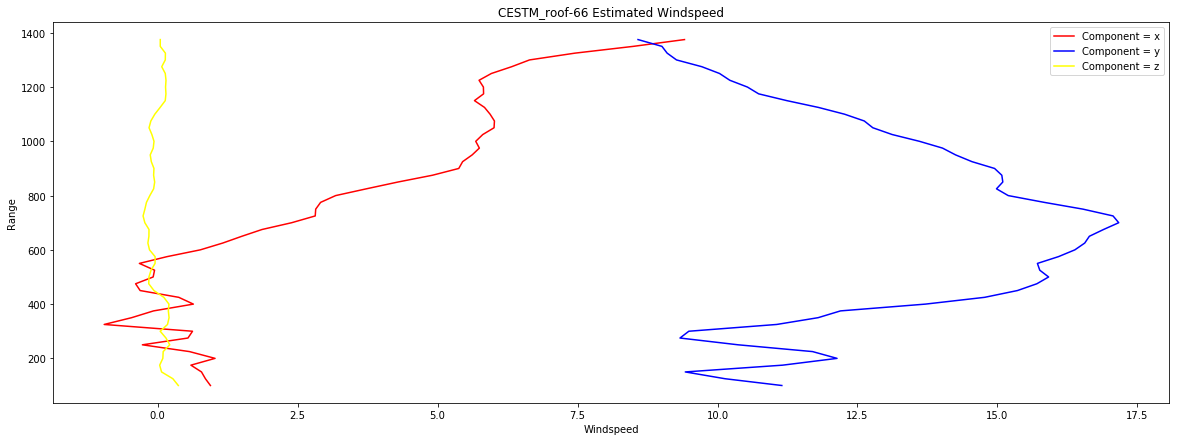

In [13]:
# vertical profile by wind component
from cycler import cycler
plt.gca().set_prop_cycle(cycler('color', ['r', 'b', '#ffff00'])) # replace the default colors
lidar['Windspeed'].isel(Timestamp=100).rasp.plot_profile(y='Range')
# see https://matplotlib.org/examples/color/color_cycle_demo.html for more tips for styling multiline plots
plt.gca().set_title('CESTM_roof-66 Estimated Windspeed')

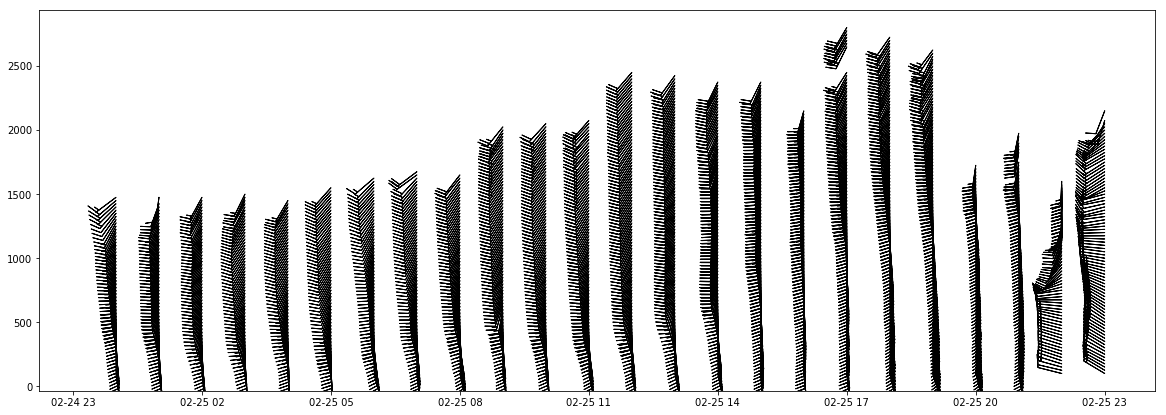

In [10]:
# plot wind barbs
lidar['Windspeed'].rasp.plot_barbs(x='Timestamp', y='Range', resample='1H')

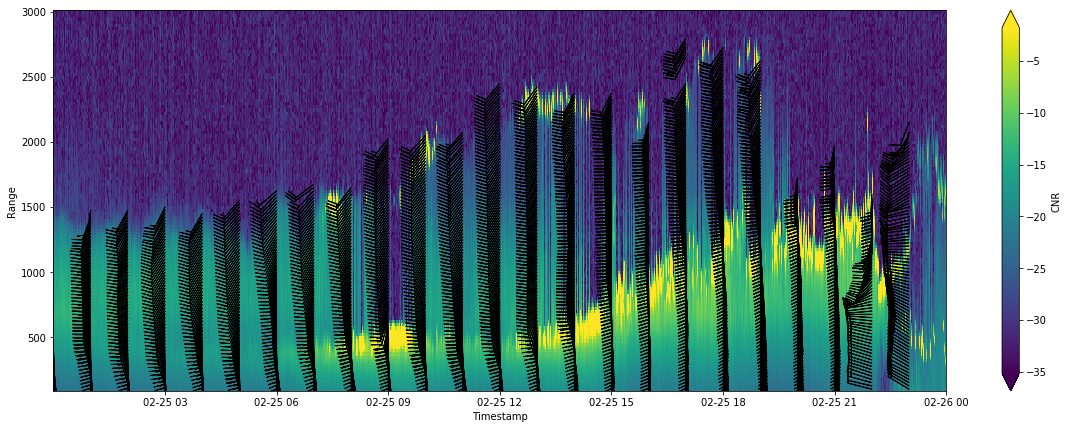

In [11]:
# plot CNR data with wind barbs
ax1 = plt.subplot(111)
lidar['CNR'].plot(x='Timestamp', y='Range', center=False, robust=True, ax=ax1)
lidar['Windspeed'].rasp.plot_barbs(x='Timestamp', y='Range', resample='1H', ax=ax1)

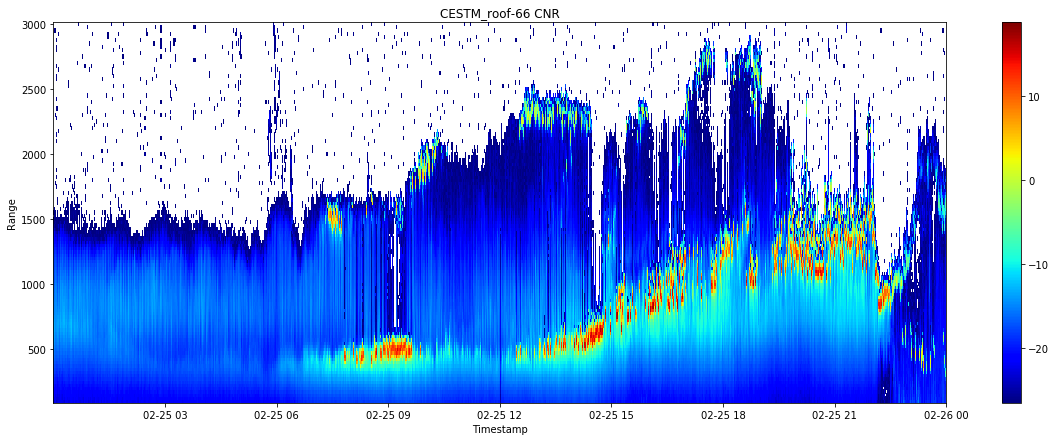

In [16]:
# An example plot 
lidar['CNR'].where(lidar['Status']).plot(x='Timestamp', y='Range', center=False, cmap='jet')
plt.gca().set_title('CESTM_roof-66 CNR') # set the title

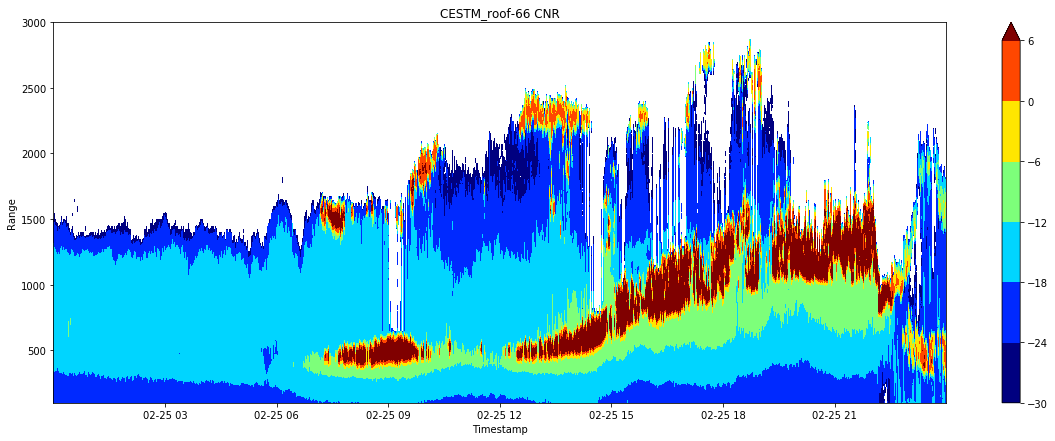

In [18]:
# example filled contour plot
lidar['CNR'].where(lidar['Status']).plot.contourf(x='Timestamp', y='Range', center=False, robust=True, cmap='jet')
plt.gca().set_title('CESTM_roof-66 CNR') # set the title

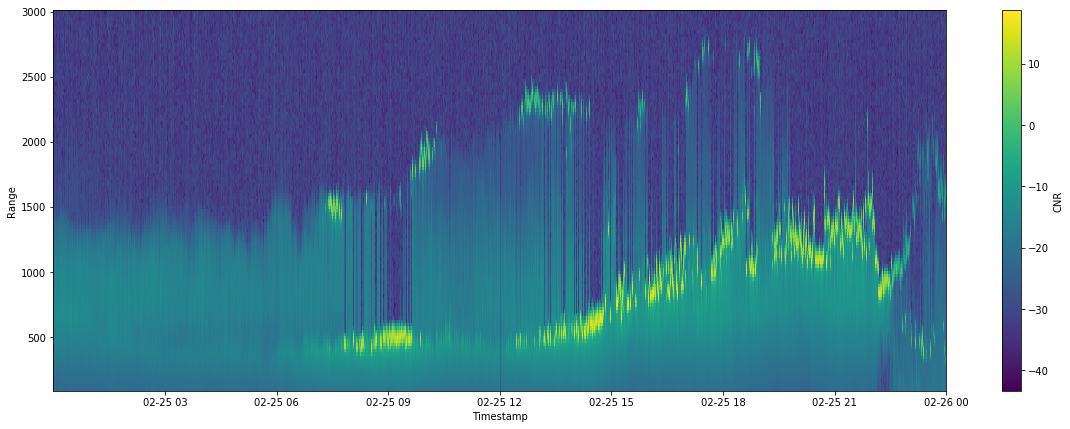

In [11]:
# save the plot
lidar['CNR'].plot(x='Timestamp', y='Range', center=False)
plt.savefig('cnr_plot.png')
# now the plot can be found by selecting File -> Open... and clicking 'cnr_plot.png'

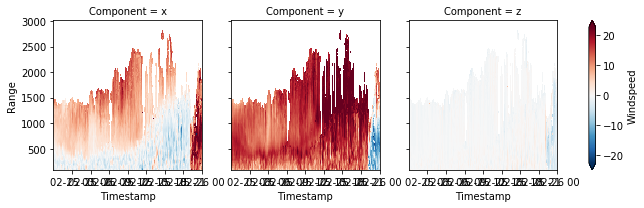

In [5]:
# plot the components of the wind speed:
lidar['Windspeed'].plot(x='Timestamp', y='Range', col='Component', robust=True)

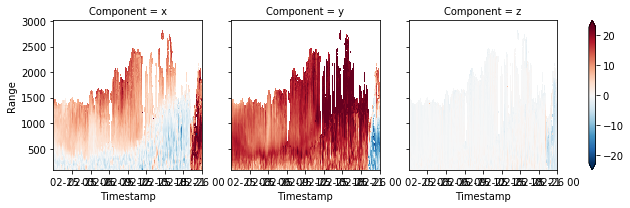

In [6]:
# Compare to above -- these estimates are calculated by raspPy and should be identical:
lidar.rasp.estimate_wind().plot(x='Timestamp', y='Range', col='Component', robust=True)

In [20]:
# aggregate by 5 minute intervals
lidar5m = lidar.resample('5T', 'Timestamp')
lidar5m

<xarray.Dataset>
Dimensions:     (Component: 3, Range: 117, Timestamp: 288)
Coordinates:
  * Component   (Component) object 'x' 'y' 'z'
  * Range       (Range) float64 100.0 125.0 150.0 175.0 200.0 225.0 250.0 ...
  * Timestamp   (Timestamp) datetime64[ns] 2017-02-25 2017-02-25T00:05:00 ...
Data variables:
    Status      (Timestamp, Range) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    RWS         (Timestamp, Range) float64 0.08435 0.1355 0.07675 0.004163 ...
    Confidence  (Timestamp, Range) float64 100.0 100.0 100.0 100.0 100.0 ...
    Error       (Timestamp, Range) float64 6.391 5.786 5.388 4.73 4.247 ...
    CNR         (Timestamp, Range) float64 -22.39 -22.1 -21.79 -21.44 -21.03 ...
    DRWS        (Timestamp, Range) float64 1.023 0.9383 0.9062 0.839 0.7965 ...
    Windspeed   (Timestamp, Component, Range) float64 -0.5867 -0.07742 ...

In [ ]:
# write to netcdf (can be read back into xarray later)
lidar5m.to_netcdf('lidar1.nc')

In [21]:
# To look at line of sight (LOS)-specific data, it helps to reorganize the dataset to use LOS ID as a dimension.
# Switch to LOS format and print the new xarray object:
lidar2 = lidar.rasp.los_format()
lidar2

<xarray.Dataset>
Dimensions:           (Component: 3, LOS ID: 5, Range: 117, scan: 4183)
Coordinates:
  * Component         (Component) object 'x' 'y' 'z'
  * Range             (Range) float64 100.0 125.0 150.0 175.0 200.0 225.0 ...
    Timestamp         (scan, LOS ID) datetime64[ns] 2017-02-25T00:00:01.746431 ...
    Azimuth           (scan, LOS ID) float64 nan nan nan nan 0.002106 ...
    Elevation         (scan, LOS ID) float64 nan nan nan nan 90.0 75.0 75.0 ...
    Configuration ID  (scan, LOS ID) float64 nan nan nan nan 7.0 7.0 7.0 7.0 ...
  * scan              (scan) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * LOS ID            (LOS ID) int64 0 1 2 3 4
Data variables:
    Status            (Range, scan, LOS ID) object nan nan nan nan True True ...
    RWS               (Range, scan, LOS ID) float64 nan nan nan nan 0.8573 ...
    Confidence        (Range, scan, LOS ID) float64 nan nan nan nan 100.0 ...
    Error             (Range, scan, LOS ID) float64 nan nan nan nan 

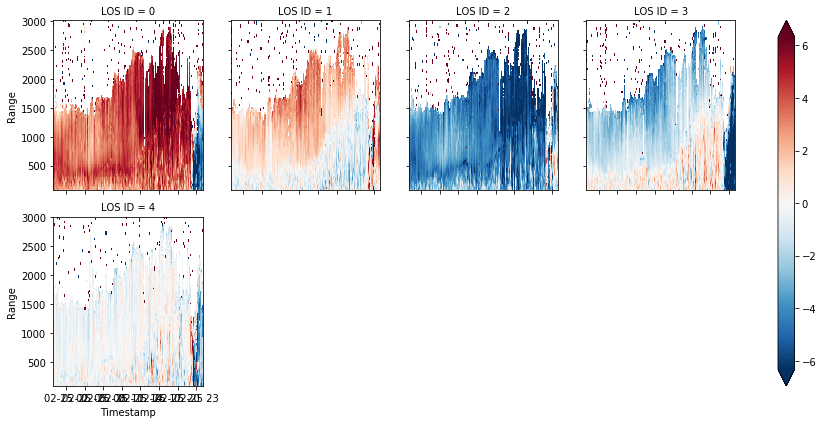

In [15]:
# plot radial wind speed for each line of sight
(-lidar2['RWS'].where(lidar2['Status'])).plot(x='Timestamp', y='Range', col='LOS ID', col_wrap=4, robust=True)
# ^ I like getting the negative so that negative values are downward

In [25]:
# The regular resample function only works if the time coordinates are a dimension in the data.
# Therefore it will not work in LOS format. You can use raspPy's nd_resample() function in this
# case.
lidar5m_los = lidar2.rasp.nd_resample('5T', 'Timestamp', 'scan')
# It takes
# 1) the time rule
# 2) the name of the time coordinate, and
# 3) the name of the dimension to resample along (this dimension will disappear, replaced by the time dimension)
lidar5m_los

<xarray.Dataset>
Dimensions:     (Component: 3, LOS ID: 5, Range: 117, Timestamp: 288)
Coordinates:
  * LOS ID      (LOS ID) int64 0 1 2 3 4
  * Component   (Component) object 'x' 'y' 'z'
  * Range       (Range) float64 100.0 125.0 150.0 175.0 200.0 225.0 250.0 ...
  * Timestamp   (Timestamp) datetime64[ns] 2017-02-25 2017-02-25T00:05:00 ...
Data variables:
    RWS         (LOS ID, Timestamp, Range) float64 -2.684 -2.91 -3.167 ...
    Confidence  (LOS ID, Timestamp, Range) float64 100.0 100.0 100.0 100.0 ...
    Error       (LOS ID, Timestamp, Range) float64 6.4 5.933 5.32 4.611 ...
    CNR         (LOS ID, Timestamp, Range) float64 -22.52 -22.25 -21.88 ...
    DRWS        (LOS ID, Timestamp, Range) float64 0.9973 0.9358 0.9106 ...
    Windspeed   (LOS ID, Timestamp, Component, Range) float64 -0.4265 ...

<a id="radiometer"></a>
## Microwave radiometer

In [2]:
# load Microwave radiometer data
mwr = mwr_from_csv('data/radiometer/cestm_3223/2017-02-25_00-04-11_lv2.csv', resample='5T',
                   attrs={'site': 'CESTM_roof-3223'})
mwr
# If the 'resample' argument is not given, this function will return the raw radiometer data.
# (It's in a slightly different format that's harder to work with.)

<xarray.Dataset>
Dimensions:            (Date/Time: 287, LV2 Processor: 4, Range: 58, Record Type: 4)
Coordinates:
  * LV2 Processor      (LV2 Processor) object 'Angle20(A)' 'Angle20(N)' ...
  * Range              (Range) float64 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 ...
  * Date/Time          (Date/Time) datetime64[ns] 2017-02-25T00:05:00 ...
  * Record Type        (Record Type) <U17 'Temperature' 'Vapor Density' ...
Data variables:
    DataQuality        (Record Type, LV2 Processor, Date/Time) float64 1.0 ...
    Temperature        (LV2 Processor, Date/Time, Range) float64 292.9 292.6 ...
    Vapor Density      (LV2 Processor, Date/Time, Range) float64 9.447 8.643 ...
    Liquid             (LV2 Processor, Date/Time, Range) float64 0.001 0.001 ...
    Relative Humidity  (LV2 Processor, Date/Time, Range) float64 55.42 55.88 ...
Attributes:
    site:     CESTM_roof-3223

In [5]:
mwr.coords['hpascals'] = ('Range', 1013.25 * np.exp(-mwr.coords['Range'] / 7))
mwr.coords['hpascals']
mwr

<xarray.Dataset>
Dimensions:            (Date/Time: 287, LV2 Processor: 4, Range: 58, Record Type: 4)
Coordinates:
  * LV2 Processor      (LV2 Processor) object 'Angle20(A)' 'Angle20(N)' ...
  * Range              (Range) float64 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 ...
  * Date/Time          (Date/Time) datetime64[ns] 2017-02-25T00:05:00 ...
  * Record Type        (Record Type) <U17 'Temperature' 'Vapor Density' ...
    hpascals           (Range) float64 1.013e+03 1.006e+03 998.9 991.8 984.7 ...
Data variables:
    DataQuality        (Record Type, LV2 Processor, Date/Time) float64 1.0 ...
    Temperature        (LV2 Processor, Date/Time, Range) float64 292.9 292.6 ...
    Vapor Density      (LV2 Processor, Date/Time, Range) float64 9.447 8.643 ...
    Liquid             (LV2 Processor, Date/Time, Range) float64 0.001 0.001 ...
    Relative Humidity  (LV2 Processor, Date/Time, Range) float64 55.42 55.88 ...
Attributes:
    site:     CESTM_roof-3223

/home/will/research/asrc/rasppy/profileTimeSeries.py:133: FutureWarning: inferring DataArray dimensions from dictionary like ``coords`` has been deprecated. Use an explicit list of ``dims`` instead.
  return xr.DataArray(cape, {'Date/Time': self._obj.coords['Date/Time']})


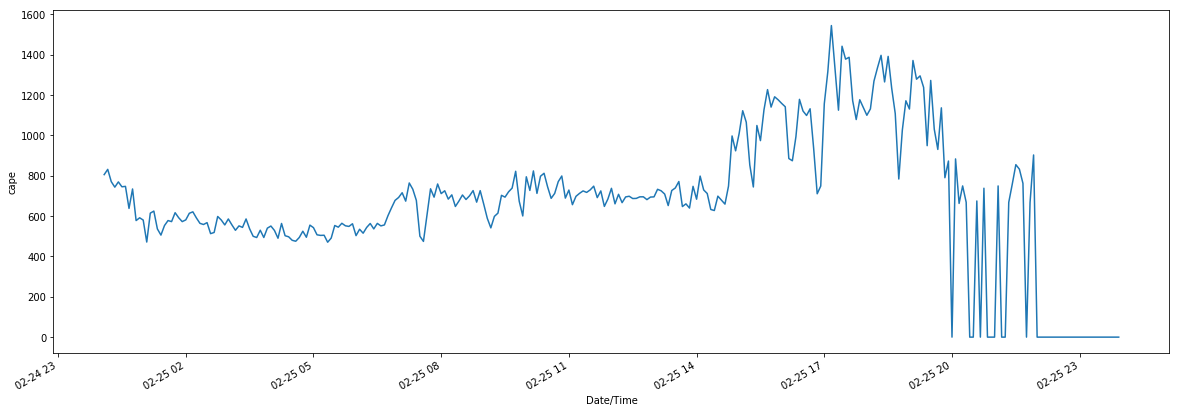

In [8]:
mwr['cape'] = mwr.sel(**{'LV2 Processor': 'Angle20(N)'}).rasp.estimate_cape()
mwr['cape'].plot()

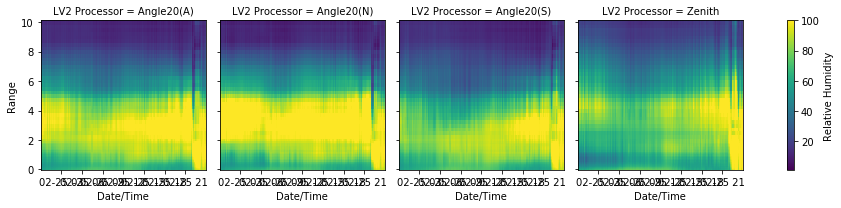

In [9]:
mwr['Relative Humidity'].plot(x='Date/Time', y='Range', col='LV2 Processor')

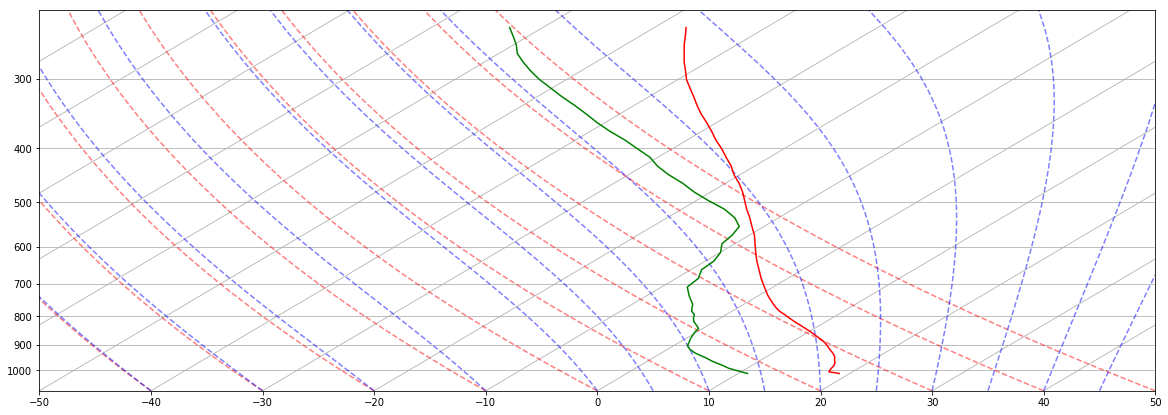

In [12]:
# with times aligned we can now plot a skewt graph
mwr.isel(**{'Date/Time': 5}).sel(**{'LV2 Processor': 'Zenith'}).rasp.skewt()

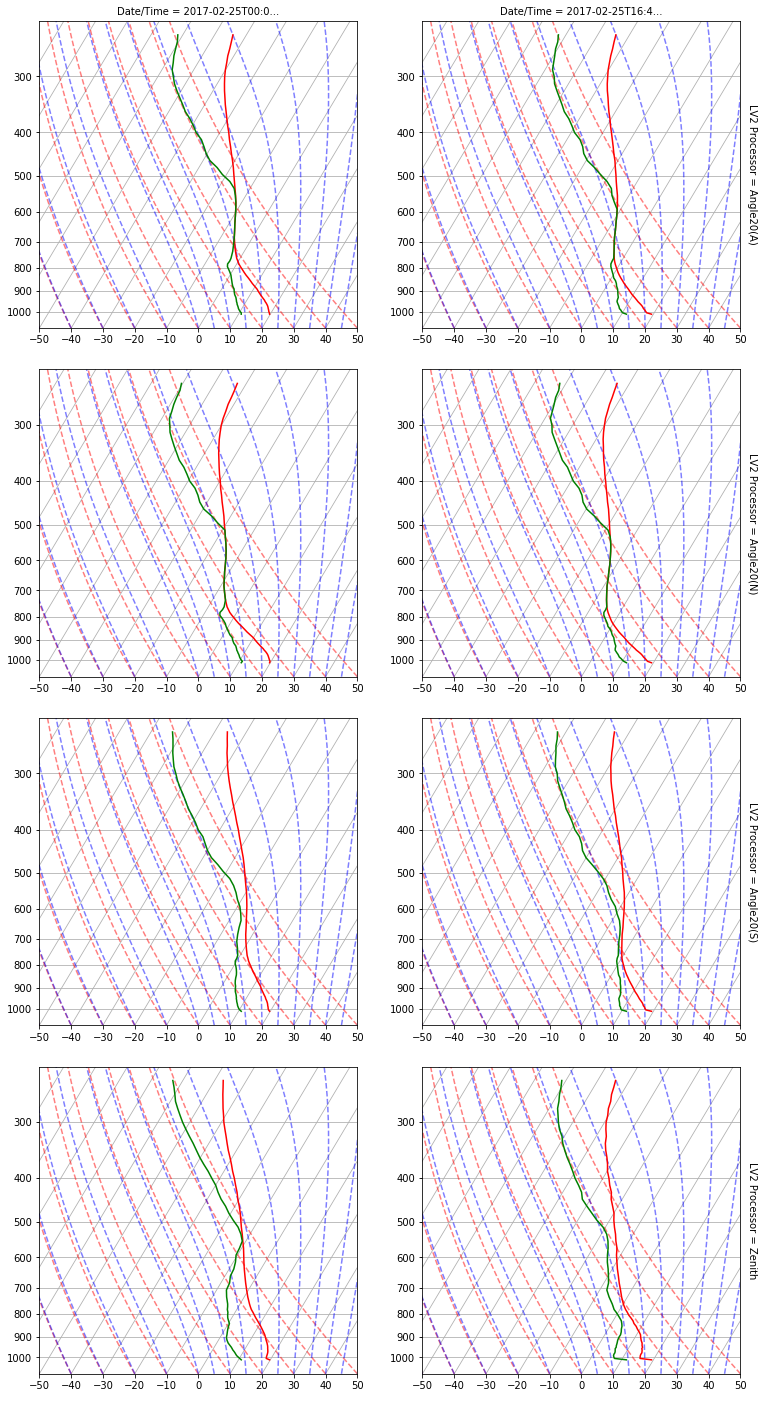

In [13]:
# can use facets with skewt as well:
mwr.isel(**{'Date/Time': [0,200]}).rasp.skewt(col='Date/Time', row='LV2 Processor', size=5)

<a id="combo"></a>
## Lidar + Microwave Radiometer

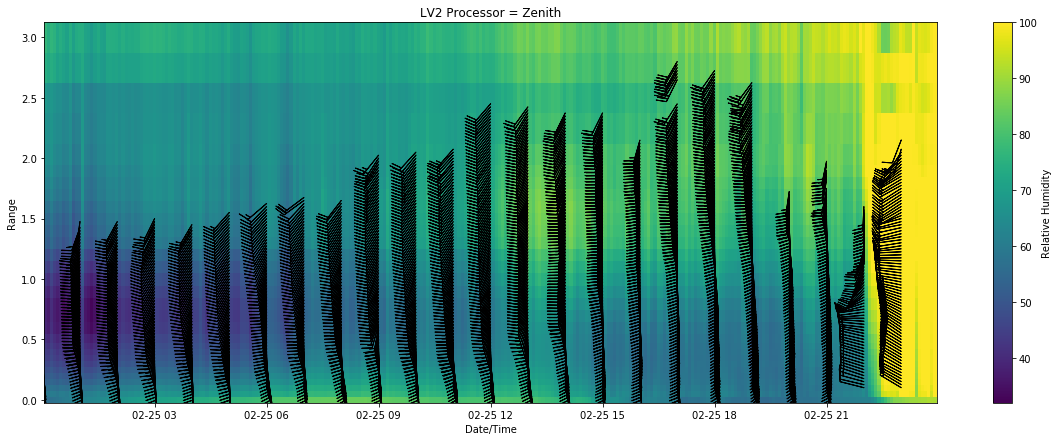

In [15]:
# microwave radiometer data with Lidar wind barbs

# requires both microwave radiometer and Lidar data to be loaded, and Lidar windspeed estimates

# create the axis for plotting
ax1 = plt.subplot(111)

# plot microwave radiometer data
mwr['Relative Humidity'].sel(**{'LV2 Processor': 'Zenith', 'Range': slice(0, 3)}).plot(x='Date/Time', y='Range', ax=ax1)

# create Lidar range coordinates in kilometers
lidar.coords['Rangekm'] = lidar.coords['Range'] / 1000
lidar.coords['Rangekm'].attrs['units'] = 'km'

# add Lidar wind barbs to the microwave radiometer graph
lidar['Windspeed'].rasp.plot_barbs(y='Rangekm', resample='1H', ax=ax1)
# don't want these coords anymore:
lidar = lidar.drop('Rangekm')

In [17]:
# merge Lidar and MR datasets

# get the lidar ranges that match MR ranges, resample at 5 minutes
lidar5m = lidar.sel(Range=np.in1d(lidar.coords['Range'] / 1000, mwr.coords['Range'].values)).resample('5T', 'Timestamp')
lidar5m.coords['Range'] = lidar5m.coords['Range'] / 1000

# rename 'Date/Time' so it matches the Lidar's 'Timestamp' dimension
lidar_mwr = xr.merge([lidar5m, mwr.rename({'Date/Time': 'Timestamp'})])
lidar_mwr.attrs['latitude'] = 42.69213
lidar_mwr.attrs['longitude'] = -73.83223
lidar_mwr

<xarray.Dataset>
Dimensions:            (Component: 3, LV2 Processor: 4, Range: 58, Record Type: 4, Timestamp: 288)
Coordinates:
  * Timestamp          (Timestamp) datetime64[ns] 2017-02-25 ...
  * Range              (Range) float64 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 ...
  * Component          (Component) object 'x' 'y' 'z'
  * LV2 Processor      (LV2 Processor) object 'Angle20(A)' 'Angle20(N)' ...
  * Record Type        (Record Type) <U17 'Temperature' 'Vapor Density' ...
    hpascals           (Range) float64 1.013e+03 1.006e+03 998.9 991.8 984.7 ...
Data variables:
    Confidence         (Timestamp, Range) float64 nan nan 100.0 100.0 100.0 ...
    Status             (Timestamp, Range) float64 nan nan 1.0 1.0 1.0 1.0 ...
    CNR                (Timestamp, Range) float64 nan nan -22.39 -21.79 ...
    DRWS               (Timestamp, Range) float64 nan nan 1.023 0.9062 ...
    RWS                (Timestamp, Range) float64 nan nan 0.08435 0.07675 ...
    Error              (Timestamp, Ra

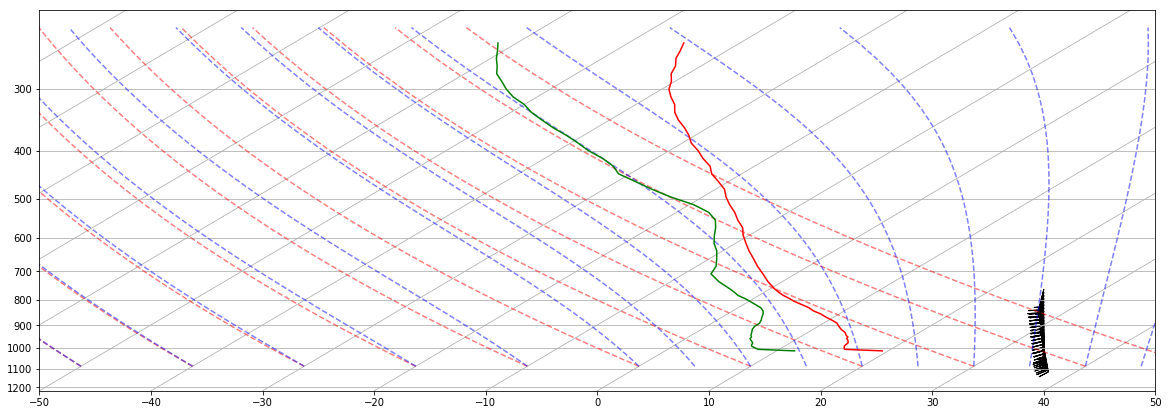

In [18]:
# plot skewt with wind
lidar_mwr.isel(**{'Timestamp': 200}).sel(**{'LV2 Processor': 'Zenith'}).rasp.skewt(wind='Windspeed')

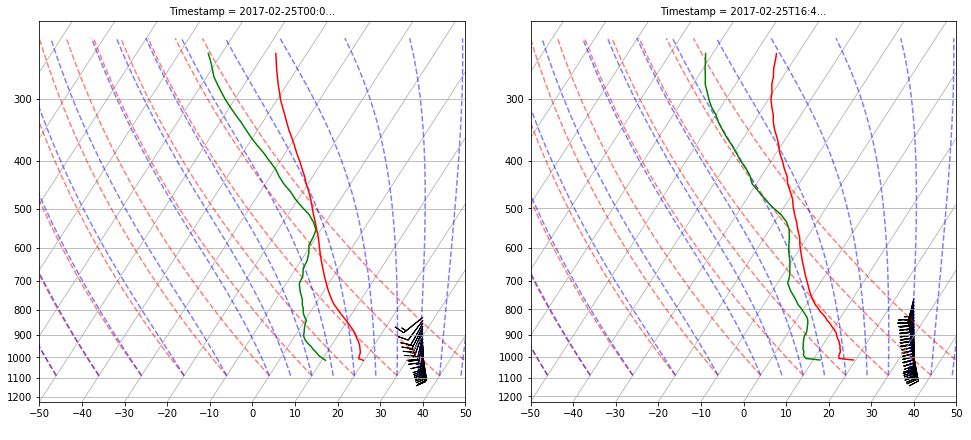

In [19]:
# plot skewt facets with wind (facets only work with the time dimension)
lidar_mwr.isel(Timestamp=[1, 200]).sel(**{'LV2 Processor': 'Zenith'}).rasp.skewt(wind='Windspeed', col='Timestamp', size=6.5)

In [21]:
# write a raob csv file
lidar_mwr.sel(**{'LV2 Processor': 'Zenith'}).rasp.write_raob(lidar_mwr.coords['Timestamp'].values[1], 'raob_test1.csv',
                                                             vap_den='Vapor Density', liq_wat='Liquid',
                                                             line_terminator='\r\n')

ValueError: dimensions or multi-index levels ['Time'] do not exist